# 0 -Thông tin chung
 * Sinh viên thực hiện:
    * Họ tên: Võ Phạm Tuấn Dũng
    * MSSV: 2010013
 * Bộ dữ liệu:
    * Tên: Oxford Pet Dataset
    * Nguồn: VGG Dataset Server
    * Kích thước: 783MB
 * Backbone:
    * Unet2D
    * Attention Unet

# 1 - Chuẩn bị tập dữ liệu

## 1.1 Chuẩn bị thư viện

In [ ]:
import os, pickle, tarfile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dropout, UpSampling2D, multiply, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomContrast

## 1.2 Tải tập dữ liệu

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz


--2023-05-29 02:08:42--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-05-29 02:08:43--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  29.3MB/s    in 27s     

2023-05-29 02:09:10 (28.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-05-29 02:09:10--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.

In [ ]:
with tarfile.open('images.tar.gz', 'r:gz') as t:
    t.extractall()
with tarfile.open('annotations.tar.gz', 'r:gz') as t:
    t.extractall()

In [ ]:
image_dir = "images/"
mask_dir = "annotations/trimaps/"
list_images_path = [image_dir + x for x in os.listdir(image_dir) if ".jpg" in x]
list_masks_path = [mask_dir + x for x in os.listdir(mask_dir) if x[0] != "." and ".png" in x]
list_images_path.sort()
list_masks_path.sort()

## 1.3 Thông tin tập dữ liệu

In [ ]:
!cat annotations/README

OXFORD-IIIT PET Dataset
-----------------------
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar

We have created a 37 category pet dataset with roughly 200 images for each class. 
The images have a large variations in scale, pose and lighting. All images have an 
associated ground truth annotation of breed, head ROI, and pixel
level trimap segmentation.

Contents:
--------
trimaps/ 	Trimap annotations for every image in the dataset
		Pixel Annotations: 1: Foreground 2:Background 3: Not classified
xmls/		Head bounding box annotations in PASCAL VOC Format

list.txt	Combined list of all images in the dataset
		Each entry in the file is of following nature:
		Image CLASS-ID SPECIES BREED ID
		ID: 1:37 Class ids
		SPECIES: 1:Cat 2:Dog
		BREED ID: 1-25:Cat 1:12:Dog
		All images with 1st letter as captial are cat images while
		images with small first letter are dog images.
trainval.txt	Files describing splits used in the paper.However,
test.txt	you are encouraged to try ra

* Ở tập dữ liệu gốc, pixel được gán nhãn như sau:
    * 1: **Forground**
    * 2: **Background**
    * 3: **Not classified**

* Để thuận tiện, ta sẽ đánh lại nhãn như sau:
    * 0: **Forground**
    * 1: **Background**
    * 2: **Other**

Số lượng ảnh và label mask: 7390

In [ ]:
print(len(list_images_path), len(list_masks_path))

7390 7390


# 2 - Hiện thực lớp phụ trợ Visualizer

Lớp **Visualizer** được xây dựng phục vụ cho mục đích hiển thị mặt nạ gồm toàn pixel label, dưới dạng ảnh RGB tương ứng.

In [ ]:
class Visualizer:
    color_dict = {
        "Red": np.array([255, 0, 0]),
        "Green": np.array([0, 255, 0]),
        "Blue": np.array([0, 0, 255]),
        "Yellow": np.array([255, 255, 0]),
        "Purple": np.array([255, 0, 255]),
        "Black": np.array([0, 0, 0]),
        "White": np.array([255, 255, 255]),
    }

    class2color = {
        0: ("Foreground", "Yellow"),
        1: ("Background", "Black"),
        2: ("Others", "Purple"),
        #
        3: ("False Positive", "Red"),
        4: ("False Negative", "Blue"),
    }

    def mask_to_rgb(self, label_mask, num_class = 3):
        channel_shape = (label_mask.shape[0], label_mask.shape[1], 1)
        red_channel = np.zeros(channel_shape, dtype = np.uint8)
        green_channel = np.zeros(channel_shape, dtype = np.uint8)
        blue_channel = np.zeros(channel_shape, dtype = np.uint8)
        for i in range(num_class):
            red_channel[label_mask == i] = self.color_dict[self.class2color[i][1]][0]
            green_channel[label_mask == i] = self.color_dict[self.class2color[i][1]][1]
            blue_channel[label_mask == i] = self.color_dict[self.class2color[i][1]][2]
        image = np.concatenate([red_channel, green_channel, blue_channel], axis = -1)
        return image

    def probs_to_rbg(self, label_image, prob_results, num_class = 3):
        pred_mask = np.argmax(prob_results, axis = -1)
        pred_mask = np.expand_dims(pred_mask, axis = -1)
        #class 0: foreground
        fp_mask = np.where((pred_mask == 0) & (label_image != 0), 3, 0)
        fn_mask = np.where((pred_mask != 0) & (label_image == 0), 4, 0)
        pred_mask = np.where(fp_mask > 0, fp_mask, pred_mask)
        pred_mask = np.where(fn_mask > 0, fn_mask, pred_mask)
        return self.mask_to_rgb(pred_mask, num_class = 5)

    def visualize_images(self, original, label_mask, output_result):
        plt.figure(figsize = (10, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(original)
        plt.title("Original Image")
        plt.subplot(1, 3, 2)
        plt.imshow(self.mask_to_rgb(label_mask))
        plt.title("Label Mask")
        plt.subplot(1, 3, 3)
        plt.imshow(self.probs_to_rbg(label_mask, output_result))
        plt.title("Predicted Mask")
        plt.legend(handles =
            [mpatches.Patch(color = self.color_dict[self.class2color[i][1]] / 255, label = self.class2color[i][0]) for i in range(5)],
            bbox_to_anchor=(-0.1, -0.1)
        )
        plt.show()

* Thuộc tính **color_dict**, **color2class**: dùng cho mục đích ánh xạ pixel label, thuộc {0,1,2}, sang màu RGB tương ứng.

* Method **mask_to_rgb**: chuyển mặt nạ nhãn thành ảnh RGB. Với một pixel label sẽ được ánh xạ thành một màu RGB tương ứng.

* Method **probs_to_rbg**: chuyển kết quả tensor xác suất của lớp Softmax (đầu ra của mô hình Unet) thành ảnh RGB tương ứng.

* Method **probsvisualize_images_to_rbg**: hiển thị ảnh gốc, ảnh RGB tương ứng vs nhãn và kết quả dự đoán

# 3 - Hiện thực lớp Dataset, Loader

## 3.1 Dataset và Augmentator

In [ ]:
class Augementator:
    def __init__(self):
        self.affine_augment = tf.keras.Sequential([
            RandomRotation(0.2),
            RandomFlip("horizontal_and_vertical"),
        ])

        self.color_augment = tf.keras.Sequential([
            RandomBrightness(0.2),
            RandomContrast(0.2),
        ])

    def augment(self, image, mask):
        combined = tf.concat([image, mask], axis=2)
        combined = self.affine_augment(combined)
        new_image, new_mask = combined[:, :, :3], combined[:, :, 3:]
        new_mask = tf.cast(new_mask, tf.int32)
        new_image = self.color_augment(new_image)
        return new_image, new_mask

    def __call__(self, image, mask):
        return self.augment(image, mask)

In [ ]:
class MyDataset(tf.keras.utils.Sequence):
    def __init__(self, image_size, batch_size, list_images_path, list_masks_path, augmentation = None):
        self.image_size = image_size
        self.batch_size = batch_size
        self.list_images_path = list_images_path
        self.list_masks_path = list_masks_path
        self.augmentation = augmentation

    def __len__(self):
        return len(self.list_images_path) // self.batch_size

    def __getitem__(self, batch_index):
        start_index = batch_index * self.batch_size
        image_paths = self.list_images_path[start_index: start_index + self.batch_size]
        mask_paths = self.list_masks_path[start_index: start_index + self.batch_size]
        img_arr = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 3), dtype=np.float32)
        mask_arr = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 1), dtype=np.float32)
        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img_arr[i] = img_to_array(load_img(img_path, target_size=self.image_size))
            mask_arr[i] = img_to_array(load_img(mask_path, target_size=self.image_size,
                            color_mode="grayscale")).astype(np.uint8) - 1
            if self.augmentation is not None:
                img_arr[i], mask_arr[i] = self.augmentation(img_arr[i], mask_arr[i])
        return img_arr / 255, mask_arr

## 3.2 Loader

In [ ]:
class MyLoader:
    def __init__(self, image_size, batch_size, list_image_paths, list_mask_paths, shuffle = True):
        self.image_size = image_size
        self.batch_size = batch_size
        self.list_image_paths = list_image_paths
        self.list_mask_paths = list_mask_paths
        self.num_samples = len(list_image_paths)
        self.train_validation_test = (0.7, 0.15, 0.15)
        self.shuffle = shuffle

    def split_dataset(self):
        if self.shuffle:
            index = np.random.permutation(self.num_samples)
            self.list_image_paths = [self.list_image_paths[i] for i in index]
            self.list_mask_paths = [self.list_mask_paths[i] for i in index]
        idx_1 = int(self.num_samples * self.train_validation_test[0])
        idx_2 = idx_1 + int(self.num_samples * self.train_validation_test[1])
        train_image_paths, train_mask_paths = self.list_image_paths[:idx_1], self.list_mask_paths[:idx_1]
        validation_image_paths, validation_mask_paths = self.list_image_paths[idx_1:idx_2], self.list_mask_paths[idx_1:idx_2]
        test_image_paths, test_mask_paths = self.list_image_paths[idx_2:], self.list_mask_paths[idx_2:]
        #
        train_set = MyDataset(self.image_size, self.batch_size,
                            train_image_paths, train_mask_paths, Augementator())
        validation_set = MyDataset(self.image_size, self.batch_size,
                            validation_image_paths, validation_mask_paths)
        test_set = MyDataset(self.image_size, self.batch_size,
                            test_image_paths, test_mask_paths)
        return train_set, validation_set, test_set

    def show_example(self, dataset, num_examples = 1):
        for _ in range(num_examples):
            i = np.random.randint(0, len(dataset))
            img, mask = dataset[i]
            img, mask = img[0], mask[0]
            img *= 255
            plt.figure(figsize=(5, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img.astype(np.uint8))
            plt.subplot(1, 2, 2)
            mask = Visualizer().mask_to_rgb(mask)
            plt.imshow(mask.astype(np.uint8))
            plt.show()

## 3.3 Kiểm thử dataset và loader

**Một số chú ý liên quan đến Dataset và Loader đã hiện thực**


* Ta thực hiện shuffle cho toàn bộ tập dữ liệu ngay từ đầu.
* Chia tập dữ liệu thành 3 tập train, dev(validation), test. Tập dev hay validation trong quá trình huấn luyện. Tập test là tập mô hình không nhìn thấy trước đó, dùng để đánh giá hiệu năng mô hình.
* Ta chỉ thực hiện augementation cho tập train set.


161 34 34


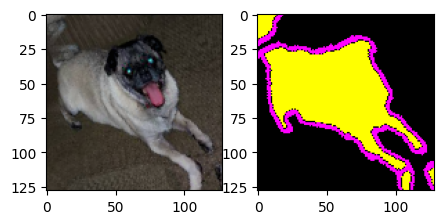

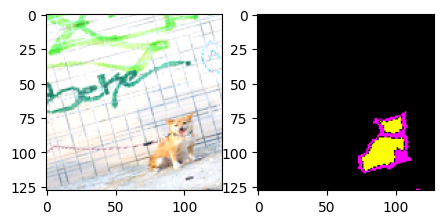

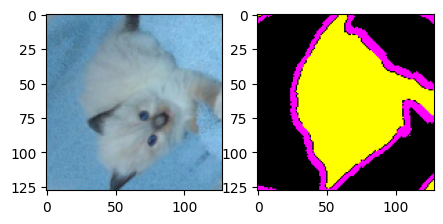

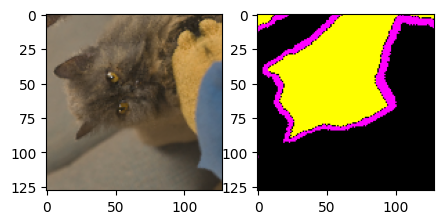

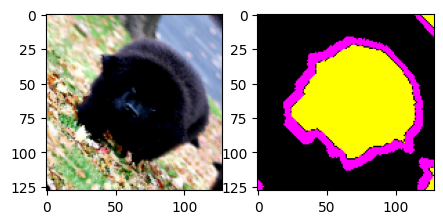

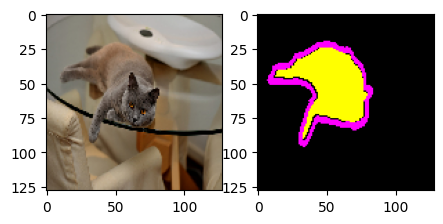

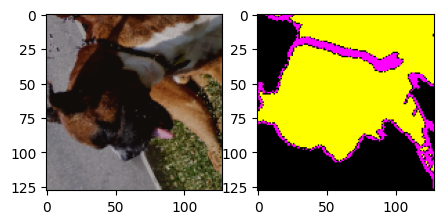

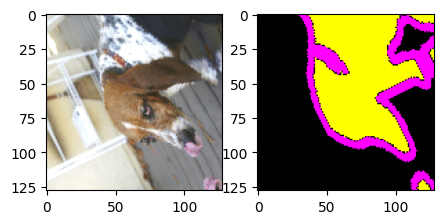

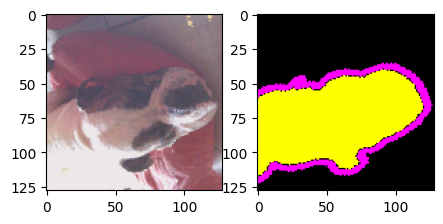

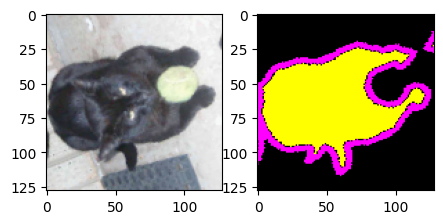

In [ ]:
loader = MyLoader((128, 128), 32, list_images_path, list_masks_path)
train_set, validation_set, test_set = loader.split_dataset()
print(len(train_set), len(validation_set), len(test_set)) #số lượng batch mỗi tập
loader.show_example(train_set, num_examples = 10)

In [ ]:
train_masks = train_set[0][1]
pixel_labels = np.unique(train_masks.reshape(1, -1))
print(pixel_labels)


[0. 1. 2.]


# 4 - Xây dựng U-net model

## 4.1 Unet2D


<img src = "https://www.mdpi.com/applsci/applsci-13-00329/article_deploy/html/images/applsci-13-00329-g001.png"/>

In [ ]:
class Unet2DBuilder():
    def __init__(self):
        self.model = self.build()

    def __call__(self):
        return self.model

    def create_conv_block(self, input, num_filter):
        x = Conv2D(num_filter, (3, 3), padding = "same")(input)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(num_filter, (3, 3), padding = "same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def create_encoder_block(self, input, num_filter):
        skip_connect = self.create_conv_block(input, num_filter)
        output = MaxPooling2D((2, 2))(skip_connect)
        return skip_connect, output

    def create_decoder_block(self, input, skip_connect, num_filter):
        x = Conv2DTranspose(num_filter, (3, 3), strides = (2, 2), padding = "same")(input)
        x = concatenate([x, skip_connect], axis = 3)
        x = self.create_conv_block(x, num_filter)
        return x

    def build(self, input_shape = (128, 128, 3)):
        input = Input(shape = input_shape)
        #tạo 4 encoder block
        skip_1, output_1 = self.create_encoder_block(input, 32)
        skip_2, output_2 = self.create_encoder_block(output_1, 64)
        skip_3, output_3 = self.create_encoder_block(output_2, 128)
        skip_4, output_4 = self.create_encoder_block(output_3, 256)

        #middle of unet
        output_5 = self.create_conv_block(output_4, 512)

        #tạo 4 decoder block
        output_6 = self.create_decoder_block(output_5, skip_4, 256)
        output_7 = self.create_decoder_block(output_6, skip_3, 128)
        output_8 = self.create_decoder_block(output_7, skip_2, 64)
        output_9 = self.create_decoder_block(output_8, skip_1, 32)

        #output
        #filter = số kênh đầu ra = số class = 3
        output = Conv2D(filters = 3, kernel_size = 1, padding = "same", activation = "softmax")(output_9)
        return Model(inputs = input, outputs = output, name = 'Unet-2D')

    def get_model(self):
        return self.model

In [ ]:
unet2d_model = Unet2DBuilder().get_model()
unet2d_model.summary()

Model: "Unet-2D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
last_layer_shape = unet2d_model.layers[-1].output_shape
print(last_layer_shape)

(None, 128, 128, 3)


## 4.2 Attention Unet

<img src="https://www.researchgate.net/publication/338652788/figure/fig1/AS:848323783188480@1579267559019/General-overview-of-the-proposed-Attention-U-net.ppm"/>

<img src="https://www.researchgate.net/publication/352820225/figure/fig2/AS:1040032479604738@1624974474678/The-architecture-of-the-attention-gate-based-u-net-for-Hb-segmentation-Each-colored.png">

In [ ]:
class AttUnetBuilder(Unet2DBuilder):
    #khối attention gate cải tiến so vs unet2d
    def create_attention_gate(self, feature_map, attention_map, num_filter):
        f = Conv2D(num_filter, (1, 1), padding = "same")(feature_map)
        g = Conv2D(num_filter, (1, 1), padding = "same")(attention_map)
        f = BatchNormalization()(f)
        g = BatchNormalization()(g)
        out = add([f, g])
        out = Activation("relu")(out)
        out = Conv2D(1, (1, 1), padding = "same")(out)
        out = BatchNormalization()(out)
        out = Activation("sigmoid")(out)
        out = multiply([feature_map, out])
        return out

    def create_decoder_block(self, input_feature, skip_connect, num_filter):
        x = Conv2DTranspose(num_filter, (3, 3), strides = (2, 2), padding = "same")(input_feature)
        attention = self.create_attention_gate(x, skip_connect, num_filter)
        x = concatenate([x, attention], axis = 3)
        x = self.create_conv_block(x, num_filter)
        return x

    def build(self, input_shape = (128, 128, 3)):
        inputs = Input(input_shape)
        skip_1, output_1 = self.create_encoder_block(inputs, 32)
        skip_2, output_2 = self.create_encoder_block(output_1, 64)
        skip_3, output_3 = self.create_encoder_block(output_2, 128)
        skip_4, output_4 = self.create_encoder_block(output_3, 256)
        output_5 = self.create_conv_block(output_4, 512)
        output_6 = self.create_decoder_block(output_5, skip_4, 256)
        output_7 = self.create_decoder_block(output_6, skip_3, 128)
        output_8 = self.create_decoder_block(output_7, skip_2, 64)
        output_9 = self.create_decoder_block(output_8, skip_1, 32)
        outputs = Conv2D(3, (1, 1), padding="same", activation="softmax")(output_9)
        return Model(inputs, outputs, name="Attention-UNET")



In [ ]:
att_unet_model = AttUnetBuilder().get_model()
att_unet_model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 32  128        ['conv2d_19[0][0]']              
 ormalization)                  )                                                    

In [ ]:
print(att_unet_model.layers[-1].output_shape)

(None, 128, 128, 3)


# 5 - Huấn luyện mô hình

## 5.1 Xây dựng Model Compiler

* Vì nhãn đầu vào y_true ở dạng sparse, không phải one-hot, kết quả đầu ra y_pred là tensor xác suất, ta sử dụng **sparse categorical crosentropy**

In [ ]:
class ModelCompiler:
    def __init__(self, train_set, validation_set, model, model_name):
        self.loss = "sparse_categorical_crossentropy"
        self.metric = tf.keras.metrics.MeanIoU(num_classes = 3, sparse_y_true = True, sparse_y_pred = False)
        self.optimizer = 'adam'
        self.callbacks = [ModelCheckpoint(model_name + ".h5", save_best_only = True), EarlyStopping(patience = 3, restore_best_weights = True)]
        self.verbose = 1
        self.validation_set = validation_set
        self.train_set = train_set
        self.epoch = 10
        self.model = model

    def compile(self):
        self.model.compile(loss = self.loss, optimizer = self.optimizer, metrics = [self.metric])
        return self

    def train(self):
        return self.model.fit(self.train_set, validation_data = self.validation_set, epochs = self.epoch, callbacks = self.callbacks, verbose = self.verbose)

In [ ]:
md1 = ModelCompiler(train_set, validation_set, unet2d_model, "unet-2d").compile()
md2 = ModelCompiler(train_set, validation_set, att_unet_model, "attention-unet").compile()

## 5.2 Huấn luyện mô hình Unet 2D

In [ ]:
history_1 = md1.train()

Epoch 1/10
161/161 [==============================] - 235s 1s/step - loss: 0.7135 - mean_io_u: 0.4008 - val_loss: 0.8152 - val_mean_io_u: 0.3896
Epoch 2/10
161/161 [==============================] - 202s 1s/step - loss: 0.5908 - mean_io_u: 0.4708 - val_loss: 1.0842 - val_mean_io_u: 0.3697
Epoch 3/10
161/161 [==============================] - 198s 1s/step - loss: 0.5202 - mean_io_u: 0.5231 - val_loss: 0.6998 - val_mean_io_u: 0.5296
Epoch 4/10
161/161 [==============================] - 193s 1s/step - loss: 0.4800 - mean_io_u: 0.5535 - val_loss: 0.4971 - val_mean_io_u: 0.5768
Epoch 5/10
161/161 [==============================] - 207s 1s/step - loss: 0.4507 - mean_io_u: 0.5741 - val_loss: 0.4963 - val_mean_io_u: 0.5825
Epoch 6/10
161/161 [==============================] - 204s 1s/step - loss: 0.4318 - mean_io_u: 0.5891 - val_loss: 0.4422 - val_mean_io_u: 0.6106
Epoch 7/10
161/161 [==============================] - 201s 1s/step - loss: 0.4182 - mean_io_u: 0.5991 - val_loss: 0.4662 - val_mea

## 5.3 Huấn luyện mô hình Attention Unet

In [ ]:
history = md2.train()

Epoch 1/10
161/161 [==============================] - 236s 1s/step - loss: 0.7814 - mean_io_u_1: 0.3632 - val_loss: 2.6360 - val_mean_io_u_1: 0.2026
Epoch 2/10
161/161 [==============================] - 207s 1s/step - loss: 0.6206 - mean_io_u_1: 0.4446 - val_loss: 1.3941 - val_mean_io_u_1: 0.3539
Epoch 3/10
161/161 [==============================] - 207s 1s/step - loss: 0.5586 - mean_io_u_1: 0.4879 - val_loss: 0.5577 - val_mean_io_u_1: 0.5063
Epoch 4/10
161/161 [==============================] - 209s 1s/step - loss: 0.5181 - mean_io_u_1: 0.5199 - val_loss: 0.5534 - val_mean_io_u_1: 0.5516
Epoch 5/10
161/161 [==============================] - 207s 1s/step - loss: 0.4832 - mean_io_u_1: 0.5454 - val_loss: 0.5641 - val_mean_io_u_1: 0.5680
Epoch 6/10
161/161 [==============================] - 208s 1s/step - loss: 0.4600 - mean_io_u_1: 0.5651 - val_loss: 0.4481 - val_mean_io_u_1: 0.5959
Epoch 7/10
161/161 [==============================] - 210s 1s/step - loss: 0.4425 - mean_io_u_1: 0.5774 - 

## 5.4 Lưu dữ liệu huấn luyện

In [ ]:
with open('history_1', 'wb') as file_pi:
    pickle.dump(history_1.history, file_pi)
with open('history_2', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# 6 - Đánh giá model

### 6.1 Load dữ liệu và xây dựng hàm phụ trợ

In [ ]:
history_1 = pickle.load(open('history_1', "rb"))
history_2 = pickle.load(open('history_2', "rb"))
model_1 = tf.keras.models.load_model("unet-2d.h5", compile = True)
model_2 = tf.keras.models.load_model("attention-unet.h5", compile = True)

In [ ]:
def history_visualize(history):
    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    [plt.plot(history[key], label = key) for key in history.keys() if "loss" in key]
    plt.legend()
    plt.subplot(1,2,2)
    [plt.plot(history[key], label = key) for key in history.keys() if "loss" not in key]
    plt.legend()
    plt.show()

In [ ]:
def compare_visualize(history_1, history_2, *para):
    plt.figure(figsize = (10, 5))
    if 'loss' in para:
        plt.plot(history_1["loss"], label = "Train Loss - Unet 2D")
        plt.plot(history_2["loss"], label = "Train Loss - Attention Unet")
    if 'val_loss' in para:
        plt.plot(history_1["val_loss"], label = "Validation Loss - Unet 2D")
        plt.plot(history_2["val_loss"], label = "Validation Loss - Attention Unet")
    if 'mean_iou' in para:
        plt.plot(history_1["mean_io_u"], label = "Train Mean IoU - Unet 2D")
        plt.plot(history_2["mean_io_u_1"], label = "Train Mean IoU - Attention Unet")
    if 'val_mean_iou' in para:
        plt.plot(history_1["val_mean_io_u"], label = "Validation Mean IoU - Unet 2D")
        plt.plot(history_2["val_mean_io_u_1"], label = "Validation Mean IoU - Attention Unet")
    plt.legend()
    [plt.title(x) for x in para]
    plt.show()

## 6.2 Đánh giá định lượng trên tập test set

Đánh giá dựa trên tập test_set chưa được nhìn thấy trong quá trình huấn luyện

In [ ]:
loss_1, metric_1 = unet2d_model.evaluate(test_set, verbose = 2)
loss_2, metric_2 = att_unet_model.evaluate(test_set, verbose = 2)

def create_panda_table(loss_1, metric_1, loss_2, metric_2):
    data = {
        "Model": ["UNet 2D", "Attention UNet"],
        "Loss": [loss_1, loss_2],
        "Mean-IoU": [metric_1, metric_2]
    }
    return pd.DataFrame(data)

34/34 - 7s - loss: 0.4059 - mean_io_u: 0.6356 - 7s/epoch - 214ms/step
34/34 - 7s - loss: 0.4229 - mean_io_u_1: 0.6106 - 7s/epoch - 218ms/step


In [ ]:
create_panda_table(loss_1, metric_1, loss_2, metric_2)

,Model,Loss,Mean-IoU
0,UNet 2D,0.405902,0.635559
1,Attention UNet,0.422938,0.610614


* Nhìn vô bảng, ta thấy mô hình Unet2D nhỉnh hơn mô hình Attention Unet.

## 6.3 Hiển thị một số kết quả dự đoán

### 6.3.1 Kết quả dự đoán của model Unet-2D


**False Positive, False Negative chỉ áp dụng cho lớp 0 (Foreground)**

1/1 [==============================] - 0s 21ms/step


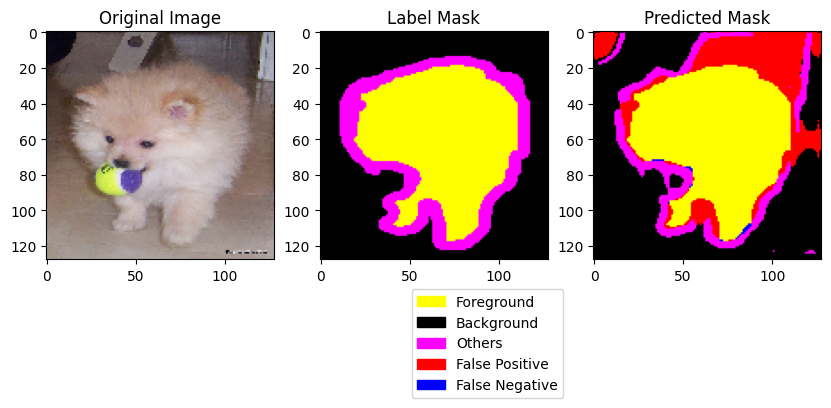

1/1 [==============================] - 0s 21ms/step


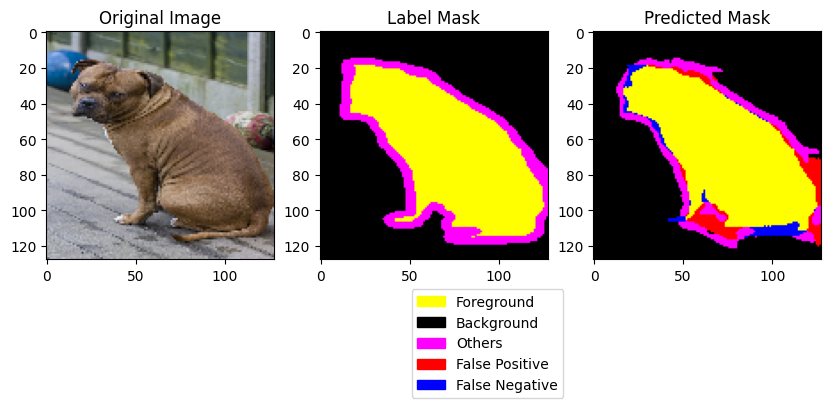

1/1 [==============================] - 0s 20ms/step


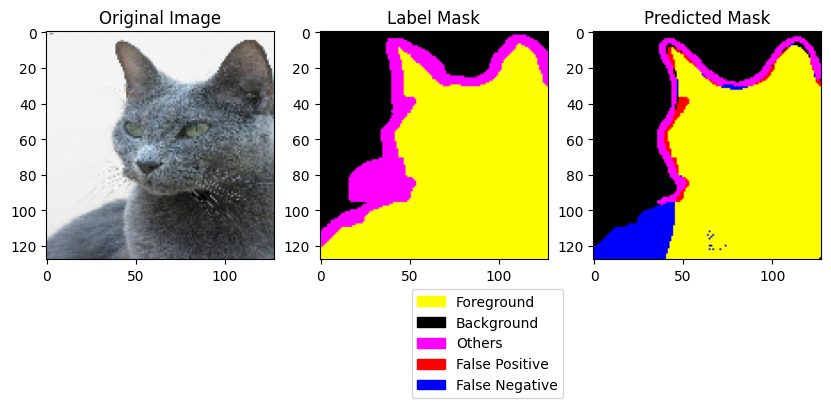

1/1 [==============================] - 0s 21ms/step


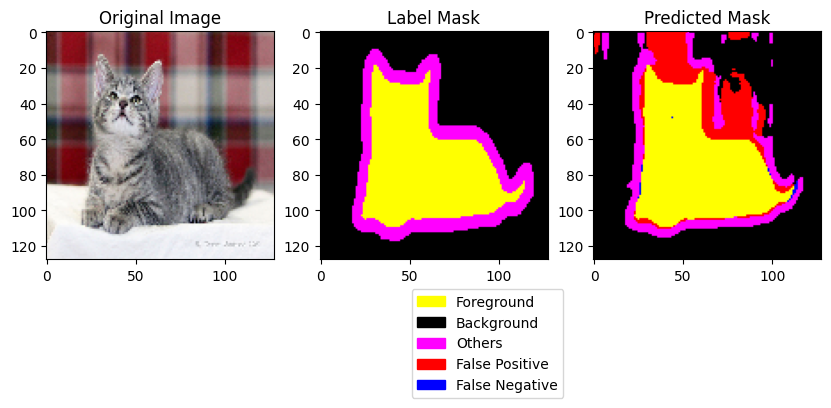

1/1 [==============================] - 0s 21ms/step


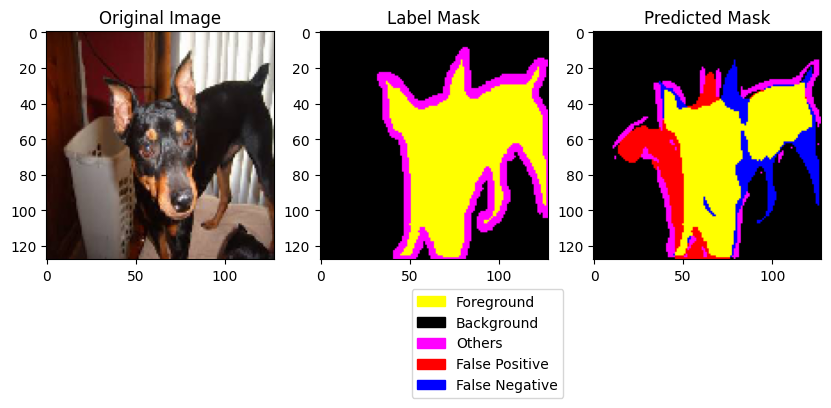

In [ ]:
viz = Visualizer()
num_show = 5
for i in range(num_show):
    rand_num = np.random.randint(0, len(test_set))
    example_image = test_set[rand_num][0][0]
    example_mask = test_set[rand_num][1][0]
    predict_result = model_1.predict(np.expand_dims(example_image, axis = 0))[0]
    viz.visualize_images(example_image, example_mask, predict_result)

### 6.3.2 Kết quả dự đoán của model Attention Unet


1/1 [==============================] - 0s 23ms/step


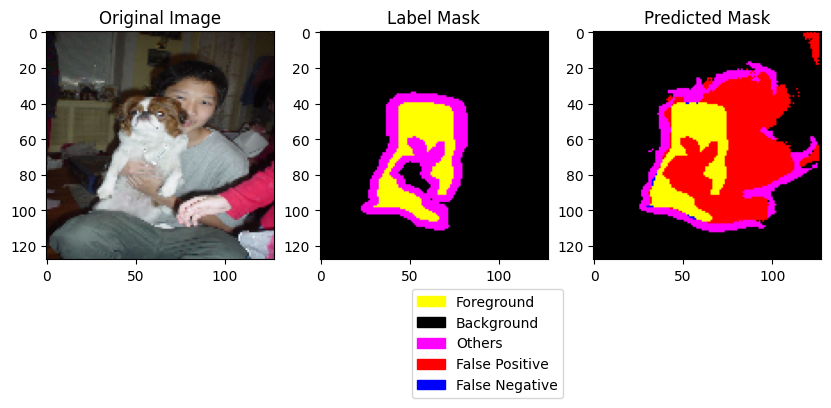

1/1 [==============================] - 0s 22ms/step


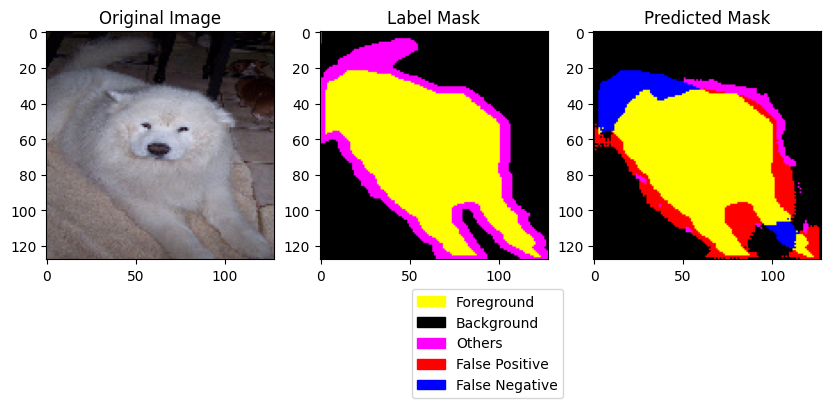

1/1 [==============================] - 0s 21ms/step


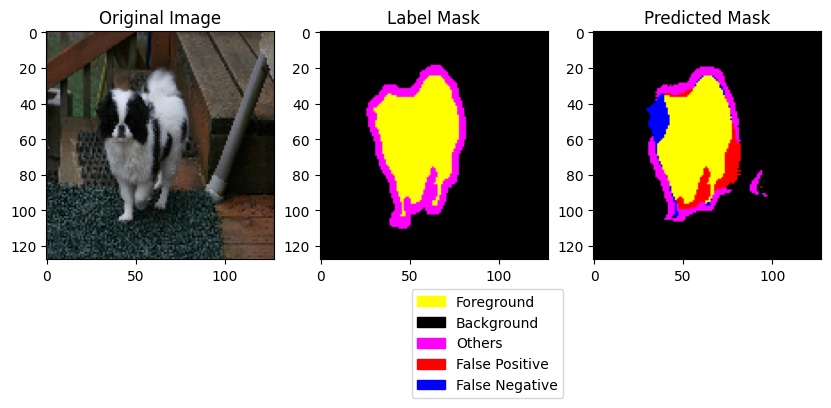

1/1 [==============================] - 0s 25ms/step


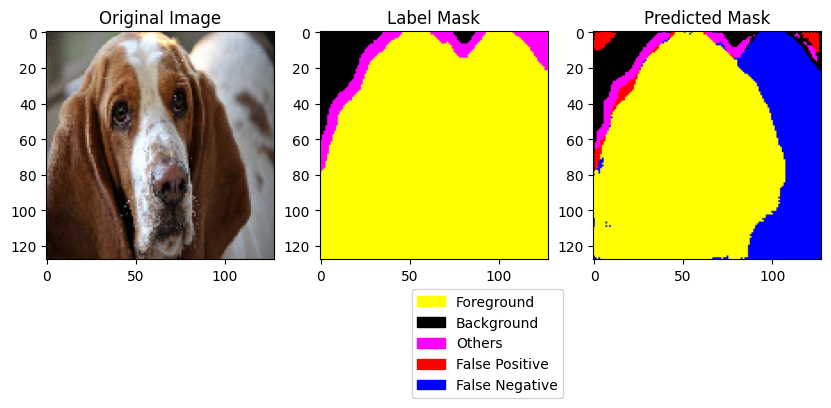

1/1 [==============================] - 0s 22ms/step


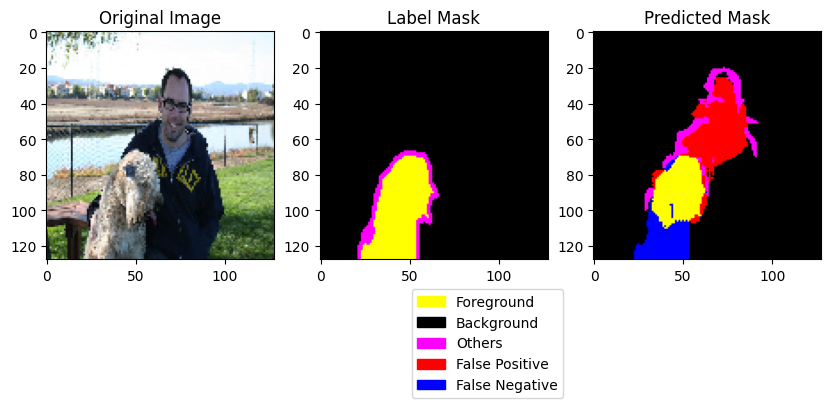

In [ ]:
for i in range(num_show):
    rand_num = np.random.randint(0, len(test_set))
    example_image = test_set[rand_num][0][0]
    example_mask = test_set[rand_num][1][0]
    predict_result = model_2.predict(np.expand_dims(example_image, axis = 0))[0]
    viz.visualize_images(example_image, example_mask, predict_result)


## 6.4 Đánh giá qua biểu đồ huấn luyện

### 6.4.1 Biểu đồ huấn luyện của mô hình Unet 2D

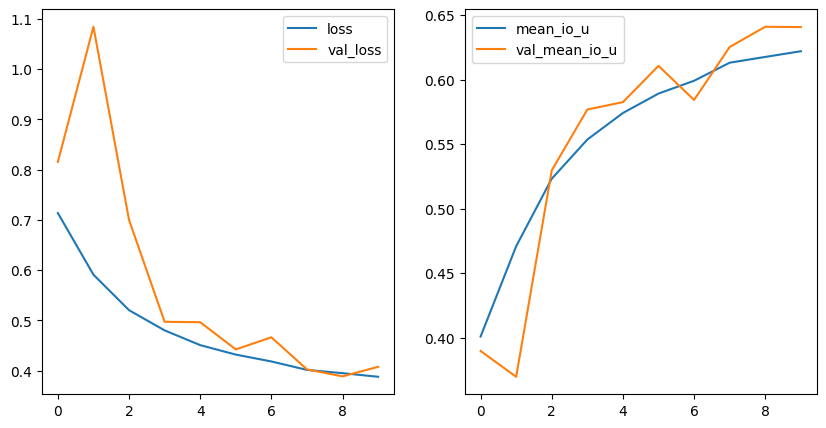

In [ ]:
history_visualize(history_1)

### 6.4.2 Biểu đồ huấn luyện của Attention Unet

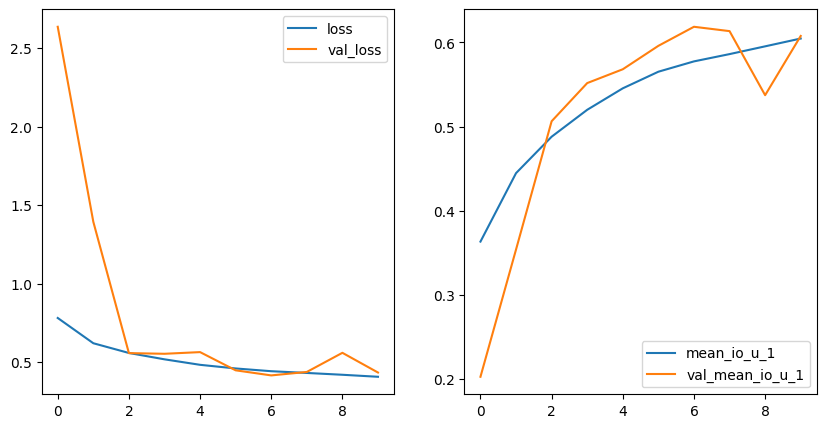

In [ ]:
history_visualize(history_2)

### 6.4.3 Biểu đồ so sánh hai mô hình

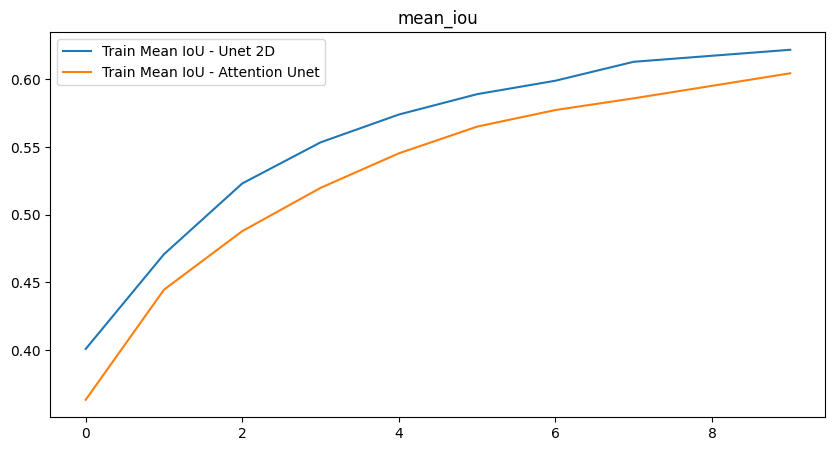

In [ ]:
compare_visualize(history_1, history_2, "mean_iou")

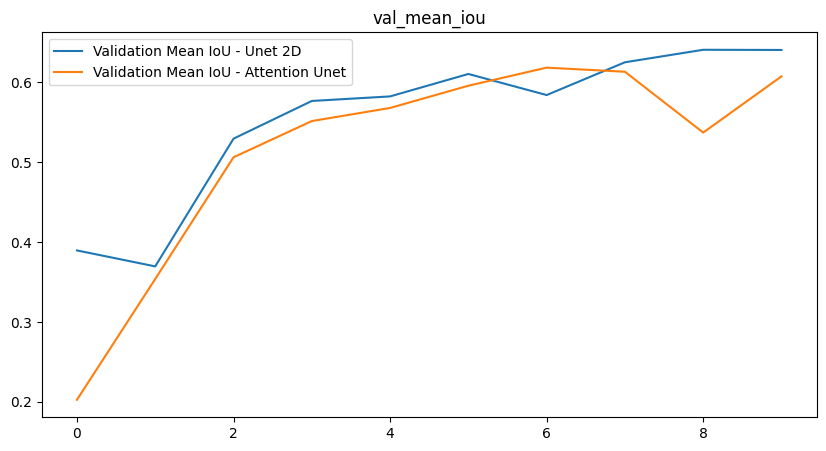

In [ ]:
compare_visualize(history_1, history_2, "val_mean_iou")

* Nhận xét: Dù có cải tiến so với Unet 2D, mô hình Attentioni Unet có độ performance không bằng Unet 2D trên bộ dữ liệu này.